# Navigate Frozen Lake

### Problem Statement
Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. 

If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend. Thus, the movement direction is uncertain and only partially depends on the chosen direction.

The surface is described using a grid like the following

| | | | |
|-|-|-|-|
|S|F|F|F|
|F|H|F|H|
|F|F|F|H|
|H|F|F|G|

$S$ : starting point, safe
<br>
$F$ : frozen surface, safe
<br>
$H$ : hole, fall to your doom
<br>
$G$ : goal, where the frisbee is located
<br>

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


### Solution Approach
Solve the problem using Monte Carlo and Temporal-Difference Learning algorithms and compare performances.

#### Import Relevant Components

In [1]:
import numpy as np
import gym
import time
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt

#### Create Environment
Using following env object, we can query information about the environment like states, actions and rewards.

In [2]:
env = gym.make("FrozenLake-v0")
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

#### Initialize Hyperparamaters

In [3]:
num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.4
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

#### Utility Functions

In [4]:
def plot(algo, rewards_all_episodes, num_episodes):
    rewards_per_thosand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/1000)
    count = 1000
    episode_steps, reward_steps = [], []
    for r in rewards_per_thosand_episodes:
        episode_steps.append(count)
        reward_steps.append(sum(r/1000))
        count += 1000
    
    plt.figure(2)
    plt.clf()        
    plt.title(algo)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.plot(episode_steps, reward_steps)

### 1. SARSA


Algorithm parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$<br>
Initialize $Q(s,a)$, for all $s \in S^{+},a \in A(s)$, arbitrarily except that $Q(terminal,·)$ = 0<br>
<br>
Loop for each episode:<br>
&emsp;Initialize $S$<br>
&emsp;Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon-greedy$)<br>
&emsp;&emsp;Loop for each step of episode:<br>
&emsp;&emsp;&emsp;Take action $A$, observe $R, S'$<br>
&emsp;&emsp;&emsp;Choose $A'$ from $S'$ using policy derived from $Q$ (e.g., $\epsilon-greedy$)<br>
&emsp;&emsp;&emsp;$Q(S, A) \gets Q(S, A) + \alpha[R + \gamma Q(S', A') - Q(S, A)]$<br>
&emsp;&emsp;&emsp;$S \gets S'; A \gets A';$<br>
&emsp;until $S$ in terminal



********Q-table: Initial********

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Running average of episodes 1-100: 0.01
Running average of episodes 101-200: 0.04
Running average of episodes 201-300: 0.09
Running average of episodes 301-400: 0.19
Running average of episodes 401-500: 0.25
Running average of episodes 501-600: 0.39
Running average of episodes 601-700: 0.24
Running average of episodes 701-800: 0.3
Running average of episodes 801-900: 0.17
Running average of episodes 901-1000: 0.23
Running average of episodes 1001-1100: 0.15
Running average of episodes 1101-1200: 0.51
Running average of episodes 1201-1300: 0.45
Running average of episodes 1301-1400: 0.61
Running average of episodes 1401-1500: 0.67
Running average of episodes 1501-1600: 0.63
Running average of episodes 1601-1700: 0.

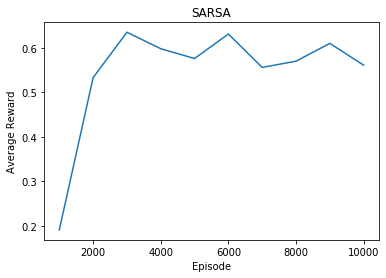

In [12]:
np.random.seed(1234)

q_table = np.zeros((state_space_size, action_space_size))
print("\n\n********Q-table: Initial********\n")
print(q_table)

rewards_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
    exploration_rate_threshold = np.random.uniform(0, 1)
    
    if exploration_rate_threshold > exploration_rate:
        action = np.argmax(q_table[state, :])
    else:
        action = env.action_space.sample()
    
    done = False
    rewards_current_episode = 0
    
    while not done:
        next_state, reward, done, info = env.step(action)
        exploration_rate_threshold = np.random.uniform(0, 1)
        
        if exploration_rate_threshold > exploration_rate:
            next_action = np.argmax(q_table[next_state, :])
        else:
            next_action = env.action_space.sample()
        
        q_table[state, action] = q_table[state, action] + learning_rate*(reward + discount_rate*q_table[next_state, next_action] - q_table[state, action])
        rewards_current_episode = rewards_current_episode + reward
        
        if done:
            break
        
        state, action = next_state, next_action
    
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)
    
    if (episode+1) % 100 == 0:
        print("Running average of episodes {}-{}: {}".format(episode-98,episode+1,np.mean(rewards_all_episodes[-100:])))

print("\n\n********Q-table: Updated********\n")
print(q_table)

plot('SARSA', rewards_all_episodes, num_episodes)

### 2. Q-Learning

Algorithm parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$<br>
Initialize $Q(s,a)$, for all $s \in S^{+},a \in A(s)$, arbitrarily except that $Q(terminal,·) = 0$<br>
<br>
Loop for each episode: <br>
&emsp;Initialize $S$<br>
&emsp;Loop for each step of episode:<br>
&emsp;&emsp;Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon-greedy$)<br>
&emsp;&emsp;Take action $A$, observe $R, S'$<br>
&emsp;&emsp;$Q(S,A) \gets Q(S,A) + \alpha[R + \gamma max_{a} Q(S',a) - Q(S,A)]$<br>
&emsp;&emsp;$S \gets S'$<br>
&emsp;until $S$ is terminal




********Q-table: Initial********

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Running average of episodes 1-100: 0.03
Running average of episodes 101-200: 0.14
Running average of episodes 201-300: 0.32
Running average of episodes 301-400: 0.54
Running average of episodes 401-500: 0.63
Running average of episodes 501-600: 0.63
Running average of episodes 601-700: 0.53
Running average of episodes 701-800: 0.5
Running average of episodes 801-900: 0.61
Running average of episodes 901-1000: 0.54
Running average of episodes 1001-1100: 0.54
Running average of episodes 1101-1200: 0.68
Running average of episodes 1201-1300: 0.65
Running average of episodes 1301-1400: 0.58
Running average of episodes 1401-1500: 0.64
Running average of episodes 1501-1600: 0.74
Running average of episodes 1601-1700: 0.

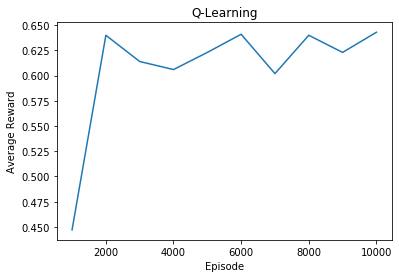

In [13]:
np.random.seed(1234)

q_table = np.zeros((state_space_size, action_space_size))
print("\n\n********Q-table: Initial********\n")
print(q_table)

rewards_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode): 

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
        learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        state = new_state
        rewards_current_episode += reward 
        
        if done == True: 
            break
    
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)
    
    if (episode+1) % 100 == 0:
        print("Running average of episodes {}-{}: {}".format(episode-98,episode+1,np.mean(rewards_all_episodes[-100:])))

        
print("\n\n********Q-table: Updated********\n")
print(q_table)

plot('Q-Learning', rewards_all_episodes, num_episodes)

### 3. Expected SARSA

Update rule in Expected SARSA is:<br>

$Q(S_{t},A_{t}) \gets Q(S_{t},A_{t}) + \alpha[R_{t+1} + \gamma E_{\pi}[Q(S_{t+1} ,A_{t+1} )|S_{t+1}] - Q(S_{t},A_{t})]$



********Q-table: Initial********

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Running average of episodes 1-100: 0.01
Running average of episodes 101-200: 0.01
Running average of episodes 201-300: 0.04
Running average of episodes 301-400: 0.11
Running average of episodes 401-500: 0.13
Running average of episodes 501-600: 0.13
Running average of episodes 601-700: 0.17
Running average of episodes 701-800: 0.14
Running average of episodes 801-900: 0.19
Running average of episodes 901-1000: 0.1
Running average of episodes 1001-1100: 0.23
Running average of episodes 1101-1200: 0.18
Running average of episodes 1201-1300: 0.11
Running average of episodes 1301-1400: 0.13
Running average of episodes 1401-1500: 0.08
Running average of episodes 1501-1600: 0.15
Running average of episodes 1601-1700: 0.

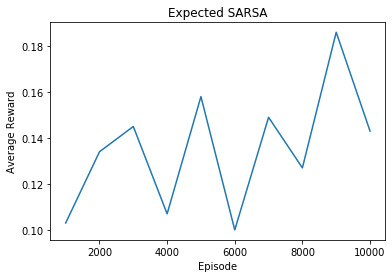

In [13]:
np.random.seed(1234)

q_table = np.zeros((state_space_size, action_space_size))
print("\n\n********Q-table: Initial********\n")
print(q_table)

rewards_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
    exploration_rate_threshold = np.random.uniform(0, 1)
    
    if exploration_rate_threshold > exploration_rate:
        action = np.argmax(q_table[state, :])
    else:
        action = env.action_space.sample()
    
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        next_state, reward, done, info = env.step(action)
        exploration_rate_threshold = np.random.uniform(0, 1)
        
        if exploration_rate_threshold > exploration_rate:
            next_action = np.argmax(q_table[next_state, :])
        else:
            next_action = env.action_space.sample()
        
        q_table[state, action] = q_table[state, action] + \
        learning_rate*(reward + discount_rate*np.mean(q_table[next_state, :]) - q_table[state, action])
        rewards_current_episode = rewards_current_episode + reward
        
        if done:
            break
        
        state, action = next_state, next_action
    
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)
    
    if (episode+1) % 100 == 0:
        print("Running average of episodes {}-{}: {}".format(episode-98,episode+1,np.mean(rewards_all_episodes[-100:])))

print("\n\n********Q-table: Updated********\n")
print(q_table)

plot('Expected SARSA', rewards_all_episodes, num_episodes)

### 4. Double Q-Learning



Algorithm parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$<br>
Initialize $Q_{1}(s,a)$ and $Q_{2}(s,a)$, for all $s \in S^{+}$, $a \in A(s)$, such that $Q(terminal,·) = 0$<br>
<br>
Loop for each episode: <br>
&emsp;Initialize $S$<br>
&emsp;Loop for each step of episode:<br>
&emsp;&emsp;Choose $A$ from $S$ using the policy $\epsilon-greedy$ in $Q_{1} + Q_{2}$<br>
&emsp;&emsp;Take action $A$, observe $R, S'$<br>
&emsp;&emsp;With 0.5 probabilility: <br>
&emsp;&emsp;&emsp;$Q_{1}(S,A) \gets Q_{1}(S,A) +\alpha(R + \gamma Q_{2}(S',argmax_{a}Q_{1}(S',a)) - Q_{1}(S,A))$<br>
&emsp;&emsp;else:<br>
&emsp;&emsp;&emsp;$Q_{2}(S,A) \gets Q_{2}(S,A) +\alpha(R + \gamma Q_{1}(S',argmax_{a}Q_{2}(S',a)) - Q_{2}(S,A))$<br>
&emsp;&emsp;$S \gets S'$<br>
&emsp;until $S$ is terminal

Running average of episodes 1-100: 0.02
Running average of episodes 101-200: 0.0
Running average of episodes 201-300: 0.0
Running average of episodes 301-400: 0.01
Running average of episodes 401-500: 0.0
Running average of episodes 501-600: 0.0
Running average of episodes 601-700: 0.0
Running average of episodes 701-800: 0.0
Running average of episodes 801-900: 0.0
Running average of episodes 901-1000: 0.0
Running average of episodes 1001-1100: 0.0
Running average of episodes 1101-1200: 0.0
Running average of episodes 1201-1300: 0.01
Running average of episodes 1301-1400: 0.0
Running average of episodes 1401-1500: 0.0
Running average of episodes 1501-1600: 0.0
Running average of episodes 1601-1700: 0.03
Running average of episodes 1701-1800: 0.23
Running average of episodes 1801-1900: 0.15
Running average of episodes 1901-2000: 0.1
Running average of episodes 2001-2100: 0.28
Running average of episodes 2101-2200: 0.4
Running average of episodes 2201-2300: 0.28
Running average of episo

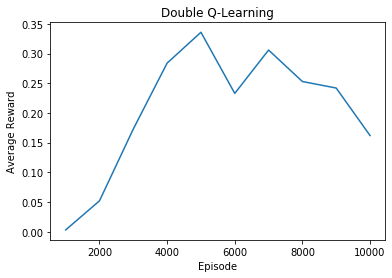

In [18]:
np.random.seed(1234)

q1_table = np.zeros((state_space_size, action_space_size))
q2_table = np.zeros((state_space_size, action_space_size))

rewards_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode): 

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q1_table[state,:] + q2_table[state,:]) 
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        
        if np.random.uniform(0, 1) > 0.5:
            q1_table[state, action] = q1_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * q2_table[new_state, np.argmax(q1_table[new_state, :])])
        else:
            q2_table[state, action] = q2_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * q1_table[new_state, np.argmax(q2_table[new_state, :])])
        
        state = new_state
        rewards_current_episode += reward 
        
        if done == True: 
            break
    
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)
    
    if (episode+1) % 100 == 0:
        print("Running average of episodes {}-{}: {}".format(episode-98,episode+1,np.mean(rewards_all_episodes[-100:])))

print("\n\n********Q1-table: Updated********\n")
print(q1_table)
print("\n\n********Q2-table: Updated********\n")
print(q2_table)

plot('Double Q-Learning', rewards_all_episodes, num_episodes)

### 5. On-policy first-visit MC control (for epsilon-soft policies), estimates policy



Algorithm parameter: small $\epsilon > 0$<br>
<br>
Initialize:<br>
&emsp;$\pi \gets$ an arbitrary $\epsilon$-soft policy<br>
&emsp;$Q(s, a) \in R$ (arbitrarily), for all $s \in S, a \in A(s)$<br>
&emsp;$Returns(s, a) \gets$ empty list, for all $s \in S, a \in A(s)$<br>
<br>
Repeat forever (for each episode):<br>
&emsp;Generate an episode following $\pi: S_{0}, A_{0}, R_{1}, . . . , S_{T-1}, A_{T-1}, R_{T}$<br>
&emsp;$G_{0} \gets 0$<br>
&emsp;Loop for each step of episode, $t = T-1,T-2,...,0$:<br>
&emsp;&emsp;$G \gets G + R_{t+1}$<br>
&emsp;&emsp;Unless the pair $S_{t}, A_{t}$ appears in $S_{0},A_{0},S_{1},A_{1}...,S_{t-1},A_{t-1}$:<br>
&emsp;&emsp;&emsp;Append $G$ to $Returns(S_{t},A_{t})$<br>
&emsp;&emsp;&emsp;$Q(S_{t}, A_{t}) \gets average(Returns(S_{t}, A_{t}))$<br>
&emsp;&emsp;&emsp;$A^{*} \gets argmax_{a} Q(S_{t},a)$ (with ties broken arbitrarily)<br>
&emsp;&emsp;&emsp;For all $a \in A(S_{t})$:<br>
&emsp;&emsp;&emsp;&emsp;if $a = A^{*}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;$\pi(a|S_{t}) \gets  1 - \epsilon + \epsilon/|A(S_{t})|$<br>
&emsp;&emsp;&emsp;&emsp;else:<br>
&emsp;&emsp;&emsp;&emsp;&emsp;$\pi(a|S_{t}) \gets \epsilon/|A(S_{t})|$



********Q-table: Initial********

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Running average of episodes 1-100: 0.02
Running average of episodes 101-200: 0.02
Running average of episodes 201-300: 0.01
Running average of episodes 301-400: 0.0
Running average of episodes 401-500: 0.0
Running average of episodes 501-600: 0.02
Running average of episodes 601-700: 0.04
Running average of episodes 701-800: 0.02
Running average of episodes 801-900: 0.03
Running average of episodes 901-1000: 0.06
Running average of episodes 1001-1100: 0.06
Running average of episodes 1101-1200: 0.05
Running average of episodes 1201-1300: 0.1
Running average of episodes 1301-1400: 0.08
Running average of episodes 1401-1500: 0.08
Running average of episodes 1501-1600: 0.12
Running average of episodes 1601-1700: 0.14

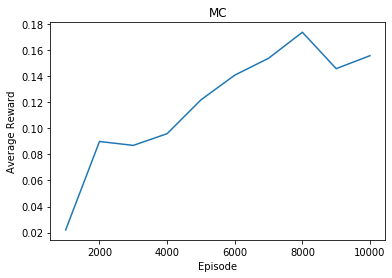

In [25]:
np.random.seed(1234)

q_table = np.zeros((state_space_size, action_space_size))
returns = {(s,a):[] for (s,a) in itertools.product(range(env.observation_space.n), range(env.action_space.n))}

print("\n\n********Q-table: Initial********\n")
print(q_table)

rewards_all_episodes = []

def policy(s, q):
    exploration_rate_threshold = np.random.uniform(0,1)
    
    if exploration_rate_threshold > exploration_rate:
        action = np.argmax(q[s,:])
    else:
        action = env.action_space.sample()
    
    return action

for episode in range(num_episodes):
    done = False
    episode_states_actions, episode_rewards = [], []
    G = 0
    rewards_current_episode = 0
    state = env.reset()
    action = policy(state, q_table)
    
    while not done:
        episode_states_actions.append((state,action))
        new_state, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        state = new_state
        action = policy(state, q_table)
        rewards_current_episode += reward
    
    for step in range(len(episode_states_actions)-1, -1, -1):
        G = reward + discount_rate*G
        
        if episode_states_actions[step] not in episode_states_actions[:step]:
            returns[episode_states_actions[step]].append(G)
            q_table[episode_states_actions[step][0], episode_states_actions[step][1]] = \
            np.mean(returns[episode_states_actions[step]])
    
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)
    
    if (episode+1) % 100 == 0:
        print("Running average of episodes {}-{}: {}".format(episode-98,episode+1,np.mean(rewards_all_episodes[-100:])))

print("\n\n********Q-table: Updated********\n")
print(q_table)

plot('MC', rewards_all_episodes, num_episodes)